In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
print(tf.__version__)

2.16.2


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Processing all images

In [4]:
%%time
images_True = []
images_False = []
image_dir = "data/images_small/traning/60-day/"
dirist = [x for x in os.listdir(image_dir) if not x.startswith(".")]
for folder_name in dirist:
    folder_dir = os.path.join(image_dir, folder_name)
    for file_name in os.listdir(folder_dir):
        file_dir = os.path.join(folder_dir, file_name)
        label = 1 if file_dir.strip().endswith("True.png") else 0
        img = cv2.imread(file_dir, cv2.IMREAD_GRAYSCALE)
        if label == 1:
            images_True.append(img)
        else:
            images_False.append(img)
images_True = np.array(images_True)
#images_True = images_True / 255.0 # --> Apparently Kelly does not scale betwen 0 and 1

images_False = np.array(images_False)
#images_False = images_False / 255.0

print(f"TRUE: {len(images_True)} images with shape {images_True[0].shape}")
print(f"FALSE: {len(images_False)} images with shape {images_False[0].shape}")

TRUE: 11542 images with shape (96, 180)
FALSE: 6498 images with shape (96, 180)
CPU times: user 952 ms, sys: 589 ms, total: 1.54 s
Wall time: 2.12 s


In [5]:
def calculate_memory_usage(image_list):
    total_bytes = sys.getsizeof(image_list)  # Get the size of the list itself
    for img in image_list:
        total_bytes += sys.getsizeof(img)  # Add the size of each image array
    
    total_gb = total_bytes / (1024 ** 3)  # Convert bytes to gigabytes
    print(f"The total memory usage of the image list is approximately {total_gb:.3f} GB.")

calculate_memory_usage(images_True)
calculate_memory_usage(images_False)

The total memory usage of the image list is approximately 0.187 GB.
The total memory usage of the image list is approximately 0.105 GB.


In [6]:
from sklearn.model_selection import train_test_split

# Step 1: Assign labels
true_labels = np.ones(len(images_True))  # Label 1 for True images
false_labels = np.zeros(len(images_False))  # Label 0 for False images

# Step 1.5: Balance the dataset
# As we have 5044 more true images than false we will remove these 
indices_to_keep = np.arange(len(images_True))  # Create an array of indices
indices_to_remove = np.random.choice(indices_to_keep, size=5044, replace=False)  # Randomly select 21,706 indices
indices_to_keep = np.setdiff1d(indices_to_keep, indices_to_remove)  # Get indices to keep
# Filter the images and labels based on the indices
images_True = images_True[indices_to_keep]
true_labels = true_labels[indices_to_keep]

# Step 2: Combine images and labels
images = np.concatenate([images_True, images_False], axis=0)
labels = np.concatenate([true_labels, false_labels], axis=0)

# Step 3: Shuffle and split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.3, random_state=42, stratify=labels
)

# Output the results
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Image shape: {X_train[0].shape}")

Training set: 9097 samples
Test set: 3899 samples
Image shape: (96, 180)


### Calculate some metris to make sure that the traning data is balances with respect to the labels

In [7]:
len(true_labels)

6498

In [8]:
len(false_labels)

6498

In [9]:
y_train.mean()

0.500054963174673

# Building the model

In [10]:
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform  # Xavier initializer

def build_cnn_model(input_shape=(96, 180)):
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(64, (5, 3), padding='same', kernel_initializer=GlorotUniform(), 
                      dilation_rate=(2, 1), input_shape=(*input_shape, 1)),  # Dilation only
        layers.BatchNormalization(),  # Batch normalization
        layers.LeakyReLU(alpha=0.1),  # Leaky ReLU with alpha=0.1
        layers.MaxPooling2D((3, 1)),  # Simulating vertical strides
        
        # Second Convolutional Block
        layers.Conv2D(128, (5, 3), padding='same', kernel_initializer=GlorotUniform(),
                      strides=(1, 1), dilation_rate=(1, 1)),  # Regular convolution
        layers.BatchNormalization(),  # Batch normalization
        layers.LeakyReLU(alpha=0.1),  # Leaky ReLU with alpha=0.1
        layers.MaxPooling2D((2, 1)),  # Pooling with size (2, 1)

        # Third Convolutional Block
        layers.Conv2D(256, (5, 3), padding='same', kernel_initializer=GlorotUniform(),
                      strides=(1, 1), dilation_rate=(1, 1)),  # Regular convolution
        layers.BatchNormalization(),  # Batch normalization
        layers.LeakyReLU(alpha=0.1),  # Leaky ReLU with alpha=0.1
        layers.MaxPooling2D((2, 1)),  # Pooling with size (2, 1)

        # Third Convolutional Block
        layers.Conv2D(512, (5, 3), padding='same', kernel_initializer=GlorotUniform(),
                      strides=(1, 1), dilation_rate=(1, 1)),  # Regular convolution
        layers.BatchNormalization(),  # Batch normalization
        layers.LeakyReLU(alpha=0.1),  # Leaky ReLU with alpha=0.1
        layers.MaxPooling2D((2, 1)),  # Pooling with size (2, 1)
        
        # Flatten and Fully Connected Layers
        layers.Flatten(),
        layers.Dense(1, kernel_initializer=GlorotUniform()),  # Fully connected layer
        layers.Dropout(0.5),  # 50% dropout
        layers.Activation('sigmoid')  # Binary classification (True/False)
    ])
    
    # Use Adam optimizer with a learning rate of 0.01
    optimizer = Adam(learning_rate=0.01)
    
    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [11]:
# Build the model
model = build_cnn_model()

# Summary of the model
model.summary()

/Users/fabiostefana/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/fabiostefana/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
2024-11-26 14:40:45.480459: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-11-26 14:40:45.480519: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-26 14:40:45.480532: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-26 14:40:45.480576: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUM

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 180, 64)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 180, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 96, 180, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 180, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 180, 128)   │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 180, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 180, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 180, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 180, 256)   │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 180, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 180, 256)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 180, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 180, 512)    │     1,966,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 180, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 180, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 180, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 368640)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       368,641 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,954,881 (11.27 MB)

 Trainable params: 2,952,961 (11.26 MB)

 Non-trainable params: 1,920 (7.50 KB)

# Traning the model

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min',  
    patience=2,  
    restore_best_weights=True
)

# Create a ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,
    patience=1,  
    min_lr=1e-6
)

# Store the callbacks in a list
callbacks = [early_stopping, reduce_lr]

# Train the model with the callbacks
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=128,
    epochs=25,
    validation_split=0.3,
    callbacks=callbacks
).history


Epoch 1/25


2024-11-26 14:40:48.462600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


50/50 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.5051 - loss: 200.7419 - val_accuracy: 0.5282 - val_loss: 210.4397 - learning_rate: 0.0100
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.4986 - loss: 21.3633 - val_accuracy: 0.5253 - val_loss: 19.0826 - learning_rate: 0.0100
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.5174 - loss: 7.5174 - val_accuracy: 0.5201 - val_loss: 5.2456 - learning_rate: 0.0100
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.5220 - loss: 2.7307 - val_accuracy: 0.5392 - val_loss: 3.1361 - learning_rate: 0.0100
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.5148 - loss: 2.0136 - val_accuracy: 0.5187 - val_loss: 1.1373 - learning_rate: 0.0100
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.5120 - loss: 1.5858 - val_accuracy: 0.4963 - val_loss: 1.1785 - learning_rate: 0.0100
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.5328 - loss: 1.3423 - val_accuracy

# Using the model

First we predict the labels for the test images, making sure that all the shapes allign

In [13]:
# Predict labels for the entire test set
test_predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", test_predictions.shape)

Predictions Shape: (3899, 1)


In [14]:
print("y_test Shape:", y_test.shape)

y_test Shape: (3899,)


Since we often encountered the problem that the model predicted True for all labels we want to check that that is not the case 

In [15]:
test_predictions

array([[0.42021108],
       [0.88246953],
       [0.5191482 ],
       ...,
       [0.4587865 ],
       [0.33976907],
       [0.6111651 ]], dtype=float32)

In [16]:
test_predictions.mean()

0.50442696

Since our model returns a probability of 

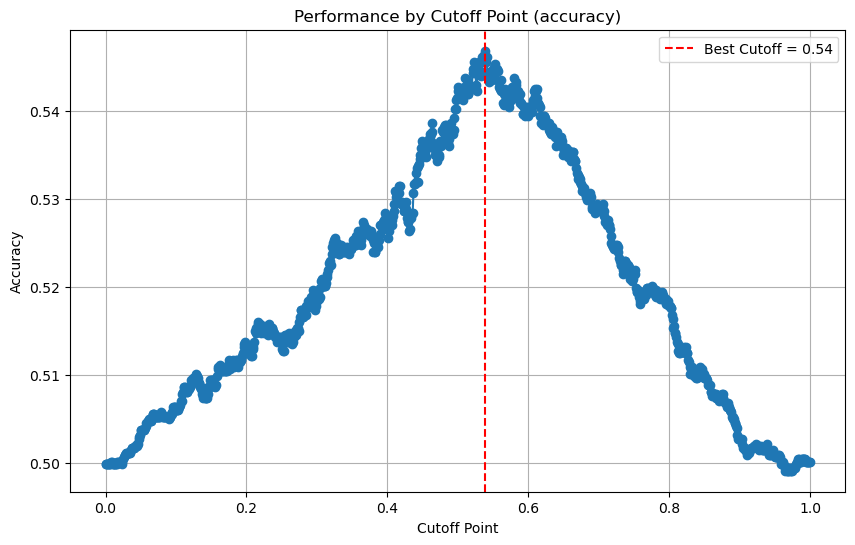

Best cutoff: 0.539 with accuracy: 0.5468


In [17]:
from sklearn.metrics import accuracy_score

def evaluate_cutoff_points(test_predictions, y_test, metric="accuracy", step=0.001):
    # Ensure y_test is an integer array
    y_test = y_test.astype(int)
    
    # Define cutoff points
    cutoff_points = np.arange(0, 1 + step, step)
    scores = []
    
    # Evaluate each cutoff
    for cutoff in cutoff_points:
        binary_predictions = np.where(test_predictions > cutoff, 1, 0)
        if metric == "accuracy":
            score = accuracy_score(y_test, binary_predictions)
        else:
            raise ValueError(f"Unsupported metric: {metric}")
        scores.append(score)
    
    # Find the best cutoff
    best_index = np.argmax(scores)
    best_cutoff = cutoff_points[best_index]
    best_score = scores[best_index]
    
    # Plot performance
    plt.figure(figsize=(10, 6))
    plt.plot(cutoff_points, scores, marker='o')
    plt.title(f"Performance by Cutoff Point ({metric})")
    plt.xlabel("Cutoff Point")
    plt.ylabel(metric.capitalize())
    plt.axvline(best_cutoff, color="red", linestyle="--", label=f"Best Cutoff = {best_cutoff:.2f}")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"Best cutoff: {best_cutoff:.3f} with {metric}: {best_score:.4f}")
    return best_cutoff

best_cutoff = evaluate_cutoff_points(test_predictions, y_test)


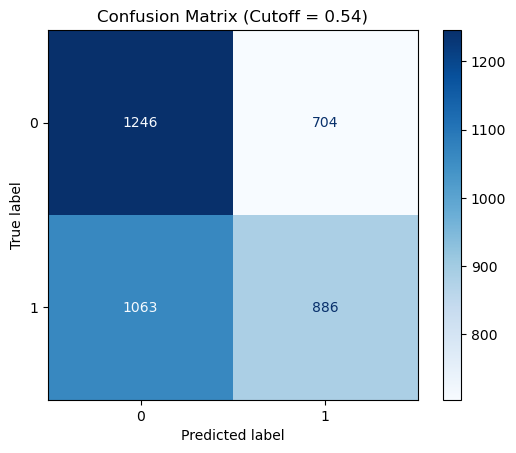

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def compute_error_matrix(test_predictions, y_test, cutoff):
    # Ensure y_test is an integer array
    y_test = y_test.astype(int)
    
    # Apply cutoff to get binary predictions
    binary_predictions = np.where(test_predictions > cutoff, 1, 0)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, binary_predictions)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix (Cutoff = {cutoff:.2f})")
    plt.show()
    
    return cm

error_matrix = compute_error_matrix(test_predictions, y_test, best_cutoff)

In [18]:
# Save the trained model to a file with the accuracy included in the filename
model_filename = 'models/60-day.keras'
model.save(model_filename)

# Some notes about this model:

First off, we repilcated kelly's methodology to the T, the only 2 variations from his model are:
1. The colour of the moving avg and volume which instad if white are 2 shades of gray
2. The data we utilized

As it is the model seems to be good enough, we have a 54.6% accuracy in predicting if the next period's return is positive or not, which gives us a roughly 5% edge on the market. While we still need to perform some out of sample testing, its looking promising, Kelly in his paper and resources did not disclose the rough results of the traning, so we cant know weather what we got is similar or completely different. 

---

One thing that we found is not great about this specific model here is that all of the predictions are very very close to 0.5, infact if we take the mean of all the test_predictions its almost exactly 0.5:

`test_predictions.mean() = 0.50007045` <br>

This suggests that the model may be uncertain or struggling to learn clear patterns in the data. 

---

While the 5-day window in kelly's results seems to be the best performing one, we feel that its a bit strange as there isnt enough history of prices to find meaningful patterns and trends in the OHLC chart, we feel that to perform trades based on technical analysis and price action a trader utilized a much longer history, and therefore we find counterintuitive that the 5 day model performs better than a longer one like the 20 day or the 60 day, we think we will find better results with the bigger time stamps.

Anyway we will perform some out of sample testing but utilizing a portfolio structure.